# Linear Regression

[Inspiration by Daniel Voigt Godoy's books](https://pytorchstepbystep.com/)

# Linear regression

In [ ]:
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from shared.step_by_step import StepByStep
from scipy.linalg import norm

from torchviz import make_dot
plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate some data

we'll use numpy for this, and also need to split the data, can also use numpy for this

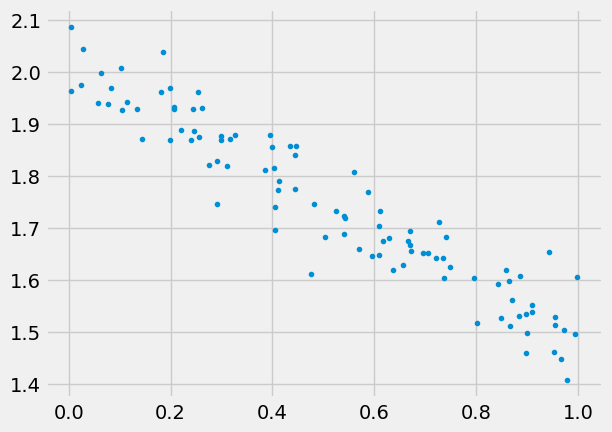

In [ ]:
np.random.seed(43)

b_true = 2.
w_true = -0.5
N = 100

x = np.random.rand(N,1)
epsilon = 0.05 * np.random.randn(N,1)
y = w_true*x + b_true + epsilon

plt.plot(x,y,'.')
plt.show()

# Linear regression with sklearn

Of course we can make a fit using sklearn:

In [ ]:
reg = LinearRegression().fit(x, y)
r2_coef = reg.score(x, y)
print(reg.coef_, reg.intercept_, r2_coef)

[[-0.52894853]] [2.01635764] 0.9014715901595961


but the point is to learn PyTorch and solve much bigger problems.

# Create datasets, data loaders

- data set is the object that holds features and labels together, 
- split the data into train and valid,
- convert to pytorch tensors,
- create datasets,
- create data_loaders.

In [ ]:
np.random.seed(43)
indices = np.arange(N)
np.random.shuffle(indices)
train_indices = indices[:int(0.8*N)]
val_indices = indices[int(0.8*N):]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_x = torch.tensor(x[train_indices], dtype=torch.float32, device=device)
train_y = torch.tensor(y[train_indices], dtype=torch.float32, device=device)
val_x = torch.tensor(x[val_indices], dtype=torch.float32, device=device)
val_y = torch.tensor(y[val_indices], dtype=torch.float32, device=device)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model, loss, and optimizer

In [ ]:
torch.random.manual_seed(42)
model = torch.nn.Linear(1,1, bias=True, device=device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.MSELoss()

# Train

In [ ]:
model.reset_parameters()
sbs = StepByStep(model, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)
sbs.train(30)

In [ ]:
sbs.model.state_dict()

OrderedDict([('weight', tensor([[-0.5267]])), ('bias', tensor([2.0177]))])

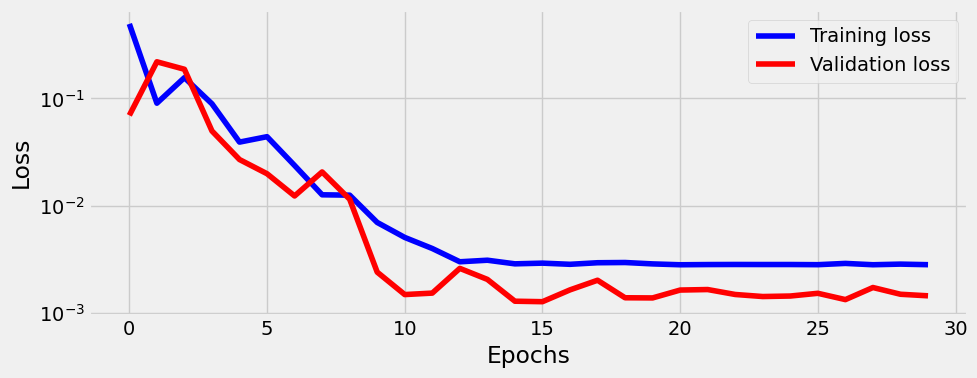

In [ ]:
sbs.plot_losses()

Note btw that `alex` and `sbs.model` are the same object:

In [ ]:
assert id(sbs.model) == id(model)

# Predict

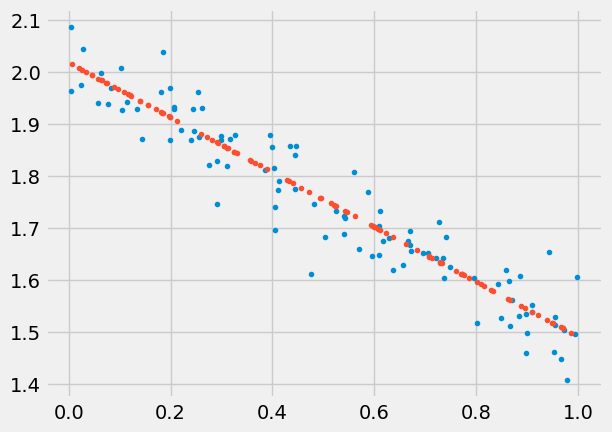

In [ ]:
test = np.random.rand(100,1)
test_predictions = sbs.predict(test)
plt.plot(x,y,'.')
plt.plot(test,test_predictions,'.')
plt.show()

#  Save/load model

In [ ]:
sbs.save_checkpoint('linear.pth')

In [ ]:
sbs.load_checkpoint('linear.pth')

# Visualize model

One can use `make_dot(yhat)` locally. I can't make graphviz work on GitHub, but the output looks like this:

<img width="300" src="images/linear_regression_model.jpg"/>

In [ ]:
#| hide 
if 'macOS' in platform.platform():
    yhat = sbs.model(torch.rand(10,1))
    make_dot(yhat)
# on Github getting error ExecutableNotFound: failed to execute Path('dot'), 
# make sure the Graphviz executables are on your systems' PATH

# Set up tensorboard

One can add tensorboard to monitor losses, this will be important when having long training. We can start tensorboard from terminal using `tensorboard --logdir runs` (or from notebook if using extension via `%load_ext tensorboard`). The tensorboard should be running at http://localhost:6006/ (ignore `"TensorFlow installation not found"` message, we don't need it). Make sure path is right, tensorboard will be empty if it can't find the `runs` folder. 

In [ ]:
#| hide
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#| hide
# tensorboard --logdir runs  # this line must sit in it's own cell not even had #| hide flag above

In [ ]:
#| hide
model.reset_parameters()
sbs = StepByStep(model, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('linear_classification')
sbs.train(30)

# Tips dataset

Let's study the linear regression model from classical perspective. Let's load a `tips` dataset where independent variables are: `total_bill, sex, smoker, day, size, time`, and depended variable is `tips`. First we simplify model by keeping only 1 independed variable, `total_bill`:

In [ ]:
# Load the dataset
tips = sns.load_dataset("tips")
tips.head()


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Let's split the data:

In [ ]:
train, valid = train_test_split(tips, test_size=0.2, random_state=42)

ValueError: could not convert string to float: 'No'

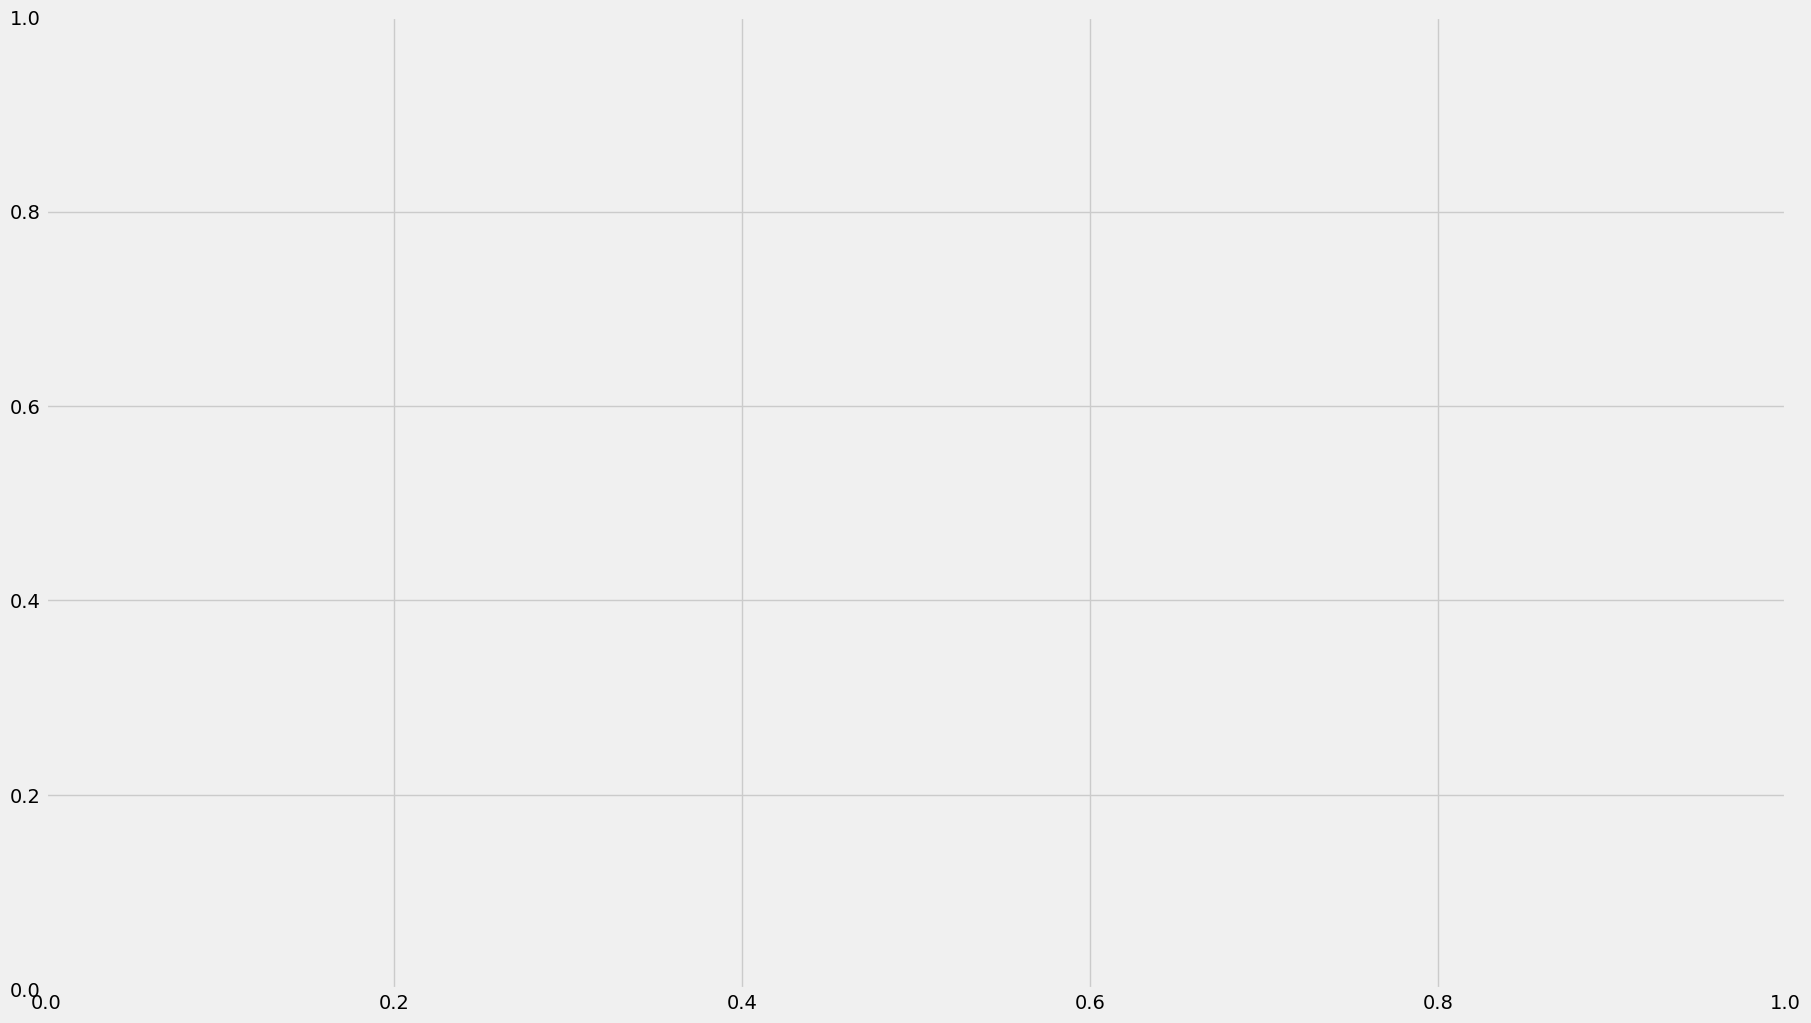

In [ ]:
plt.subplots(figsize=(20,12))
a = sns.heatmap(train.corr(numeric_only=False), cmap="seismic", annot=True, vmin=-1, vmax=1, fmt='.1f',square = True)

In [ ]:
X_train = train.total_bill.values.reshape(-1,1)
y_train = train.tip.values.reshape(-1,1)
X_valid = valid.total_bill.values.reshape(-1,1)
y_valid = valid.tip.values.reshape(-1,1)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((195, 1), (195, 1), (49, 1), (49, 1))

## sklearn.LinearRegression

Let's first use very simple linear regression model from sklearn, and only 2 columns:

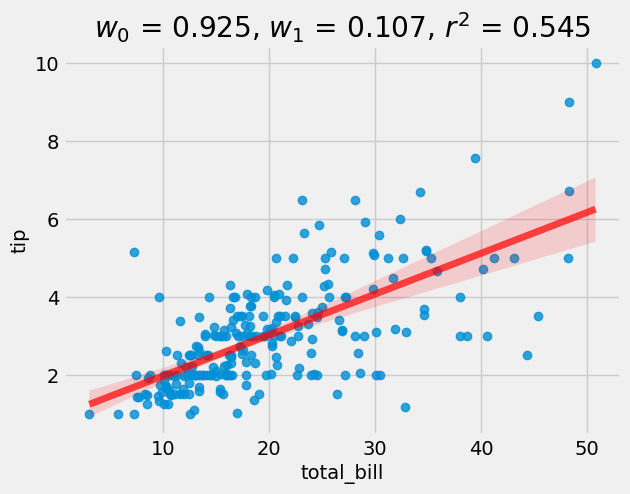

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
r2 = lr.score(X_valid, y_valid)
sns.regplot(data=tips, x="total_bill", y="tip", line_kws={"color":"r","alpha":0.7,"lw":5})
plt.title(f'$w_0$ = {float(lr.intercept_):0.3f}, $w_1$ = {float(lr.coef_):0.3f}, $r^2$ = {r2:0.3f}')
plt.show()

So we see that on average people left 10.5% tip. The r2 score is 0.597. 

## Manual


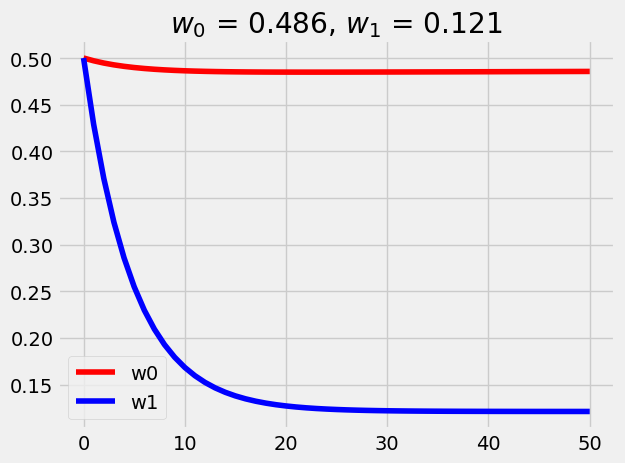

In [ ]:
w0 = 0.5
w1 = 0.5
N = len(X_train)
alpha = 2e-4

w1_list = [w0]
w0_list = [w1]
for i in range(50):
    y_new = w0 + X_train*w1
    cost_function = 1/N *np.sum((y_new - y_train)**2)

    w0 -= alpha*(1/N * 2 * np.sum(y_new - y_train))
    w1 -= alpha*(1/N * 2 * np.sum((y_new - y_train)*X_train))

    w0_list.append(w0)
    w1_list.append(w1)

sns.lineplot(x=range(len(w0_list)), y=w0_list, color='red', label='w0')
sns.lineplot(x=range(len(w1_list)), y=w1_list, color='blue', label='w1')

plt.title(f'$w_0$ = {w0:0.3f}, $w_1$ = {w1:0.3f}')
plt.show()


Interesting that w1 is slightly off 12.1% vs 10% (regularization is not a culprit). Let's plot together with the scatter plot:

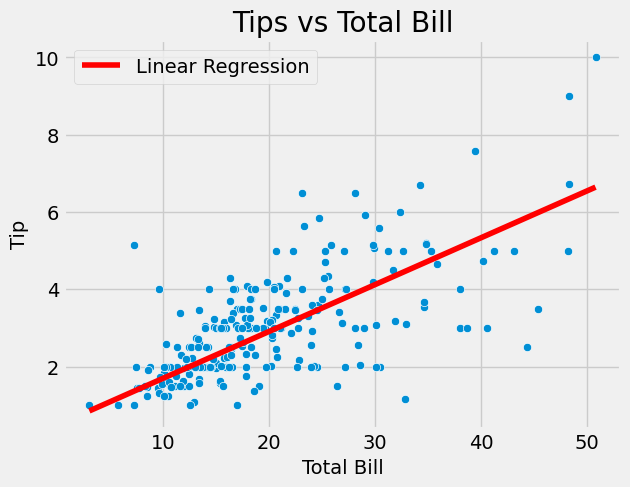

In [ ]:
# Create scatterplot
sns.scatterplot(x="total_bill", y="tip", data=tips)

# Add title and axis labels
plt.title("Tips vs Total Bill")
plt.xlabel("Total Bill")
plt.ylabel("Tip")

# seaborn plot a line
sns.lineplot(x=X_train.flatten(), y=w0 + w1*X_train.flatten(), color='red', label='Linear Regression')
# Show the plot
plt.show()

## Multivariate linear regression

Let's now include all variables:

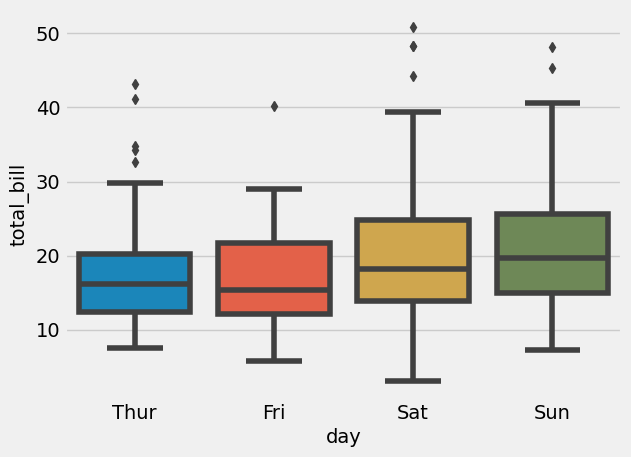

In [ ]:
_ = sns.boxplot(x="day", y="total_bill", data=tips)

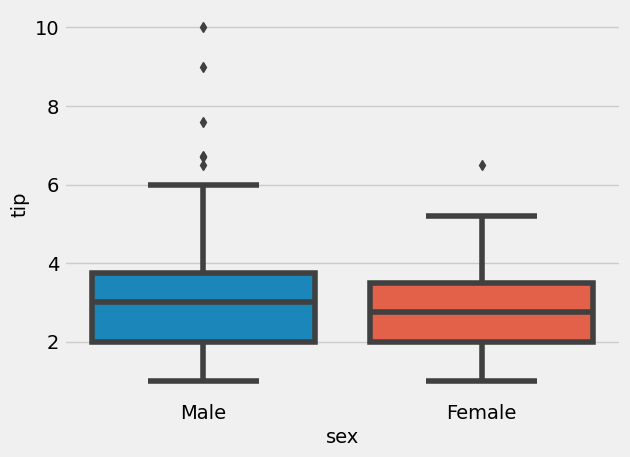

In [ ]:
_ = sns.boxplot(x="sex", y="tip", data=tips)

This graph might not mean males are bigger tipers, since it might have been that more males ate in bigger groups as well. Plotting relative tip (i.e. tip/total_bill) might be more informative:

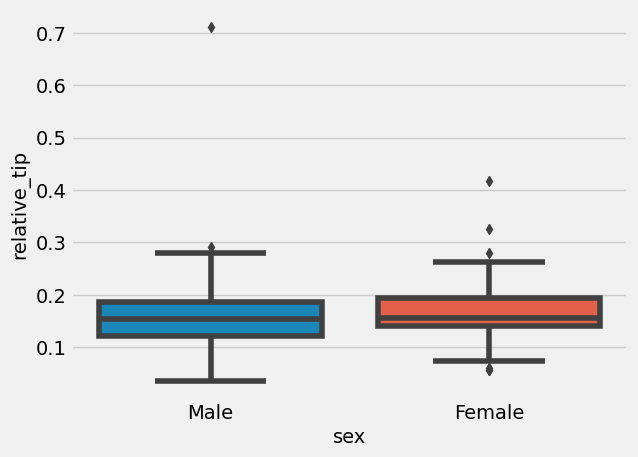

In [ ]:
tips['relative_tip'] = tips['tip'] / tips['total_bill']
_ = sns.boxplot(x="sex", y="relative_tip", data=tips)

Indeed, women left larger percentage of tip (then again, they might have had smaller portionsl there are many angles one can look at this data). How about compare group sizes:

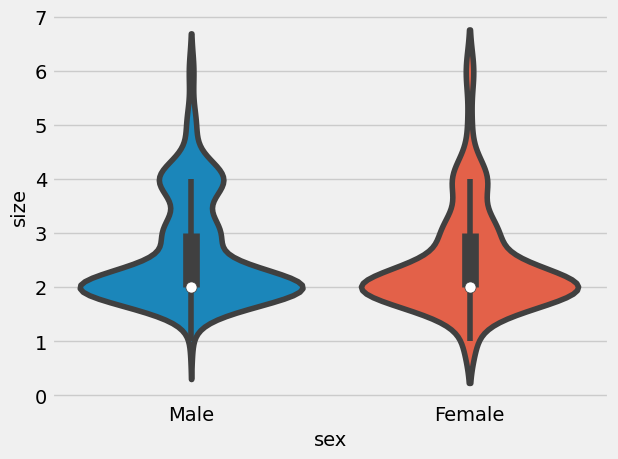

In [ ]:
_ = sns.violinplot(x="sex", y="size", data=tips)

That seems very similar distribution.

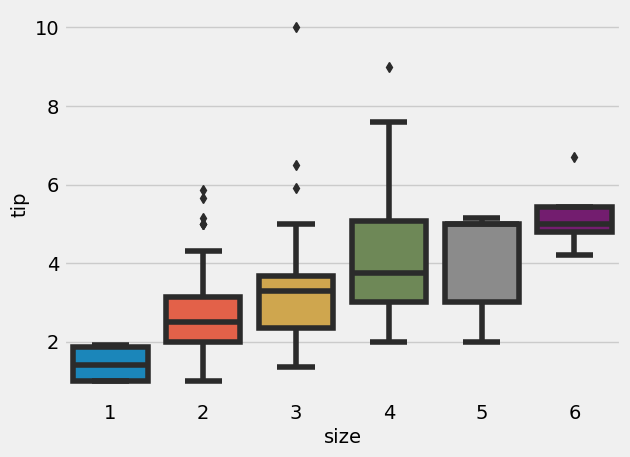

In [ ]:
_ = sns.boxplot(x="size", y="tip", data=tips)

# Multivariable linear regression

Let's run multivariable linear regression, we first need to encode all the categorical variables into numerical:

In [ ]:
tips.dtypes

total_bill     float64
tip            float64
sex           category
smoker        category
day           category
time          category
size             int64
dtype: object

In [ ]:
train.head()

,total_bill,tip,sex,smoker,day,time,size
228,13.28,2.72,Male,No,Sat,Dinner,2
208,24.27,2.03,Male,Yes,Sat,Dinner,2
96,27.28,4.00,Male,Yes,Fri,Dinner,2
167,31.71,4.50,Male,No,Sun,Dinner,4
84,15.98,2.03,Male,No,Thur,Lunch,2


In [ ]:
train_n = pd.get_dummies(train, columns=["sex"], prefix="sex")
train_n = pd.get_dummies(train_n, columns=["smoker"], prefix="smoker")
train_n = pd.get_dummies(train_n, columns=["time"], prefix="time")
train_n = pd.get_dummies(train_n, columns=["day"], prefix="day")

In [ ]:
valid_n = pd.get_dummies(valid, columns=["sex"], prefix="sex")
valid_n = pd.get_dummies(valid_n, columns=["smoker"], prefix="smoker")
valid_n = pd.get_dummies(valid_n, columns=["time"], prefix="time")
valid_n = pd.get_dummies(valid_n, columns=["day"], prefix="day")

In [ ]:
X_train = train_n.drop('tip', axis=1).values
y_train = train_n.tip.values.reshape(-1,1)
X_valid = valid_n.drop('tip', axis=1).values
y_valid = valid_n.tip.values.reshape(-1,1)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((195, 12), (195, 1), (49, 12), (49, 1))

Let's train the model:

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.coef_

array([[ 0.09469974,  0.23348393,  0.01440964, -0.01440964, -0.09617663,
         0.09617663,  0.04747858, -0.04747858, -0.07564606,  0.10407492,
        -0.08171038,  0.05328153]])

and these are the coefficients. Let's predict on valid dataset:

In [ ]:
y_valid_pred = lr.predict(X_valid)

and let's plot the predicitons and targets:

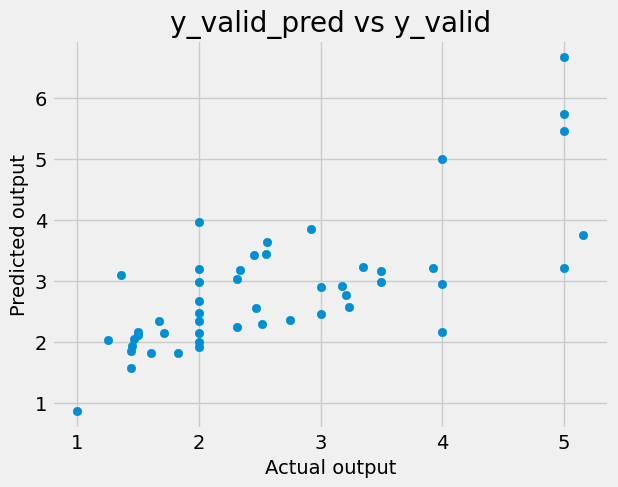

In [ ]:
# write a code to plot y_valid_pred vs y_valid
plt.scatter(y_valid, y_valid_pred)
plt.xlabel('Actual output')
plt.ylabel('Predicted output')
plt.title('y_valid_pred vs y_valid')
plt.show()

Measure of accuracy is R^2 (i.e. coefficient of determinaltion):

In [ ]:
r2 = lr.score(X_valid, y_valid)
r2

0.43730181943482505

Which is the same as:

In [ ]:
u = ((y_valid_pred - y_valid)**2).sum()
v = ((y_valid - y_valid.mean()) ** 2).sum()
1 - u/v

0.43730181943482505

And this is worse then univariable linear regression, meaning that in case of LinearRegression adding other variables made predictions worse.